# Beta (10)
Used in finance to manage risk, defines how risky a portfolio is  
- Way of measuring volatility and risk
- Stardad use: compare volatility of a share or portfolio to overall market  
- Beta of 1: as volatile as the market, moving at same speed
- Beta > 0: moves with market
- Beta < 0: moves against market
- Beta > 1 (absolute): value is more volatile  

Example: beta of TSLA is 1.48  
Means that the share moves in same direction as the market
1.5x as volatile as the market at large

### How to compute Beta
``` Beta(S) = covariance(S, Market) / variance(Market) ```  
Covariance tells us how much they move in the same direction, + move in same direction, - move in opposite  
Normalize it by dividing by the variance in the market (how volatile it is)


## Beta for Shares (11)
Rather than look at comparison with market, look at in comparison to other shares in the portfolio    
Calculate Beta between 3 different shares in a portfolio


In [43]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt




#### TAKING THE LOG HERE

In [44]:
tsla = np.log(yf.Ticker('TSLA').history(start='2015-01-01', end='2022-01-01', interval='1d').reset_index()['Close'])
amzn = np.log(yf.Ticker('AMZN').history(start='2015-01-01', end='2022-01-01', interval='1d').reset_index()['Close'])
aapl = np.log(yf.Ticker('AAPL').history(start='2015-01-01', end='2022-01-01', interval='1d').reset_index()['Close'])

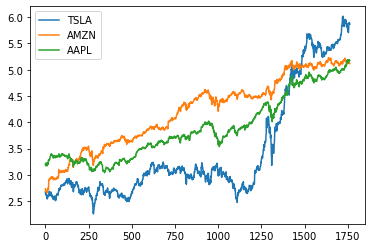

In [45]:
tsla.plot()
amzn.plot()
aapl.plot()
plt.legend(['TSLA','AMZN','AAPL'])
plt.show()

#### Look at diffs to make stationary

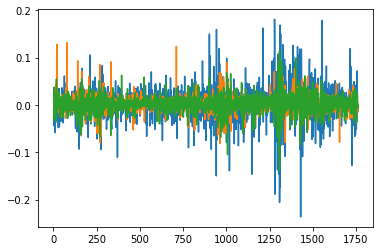

In [46]:
tsla_diffs = (tsla - tsla.shift())[1:]
amzn_diffs = (amzn - amzn.shift())[1:]
aapl_diffs = (aapl - aapl.shift())[1:]

tsla_diffs.plot()
amzn_diffs.plot()
aapl_diffs.plot()
plt.show()

Can't really see much from this so visualize a different way.  

Visualize as a scatter plot

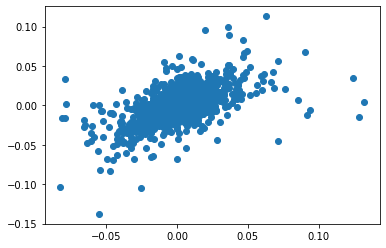

In [47]:
plt.scatter(amzn_diffs, aapl_diffs)
plt.show()

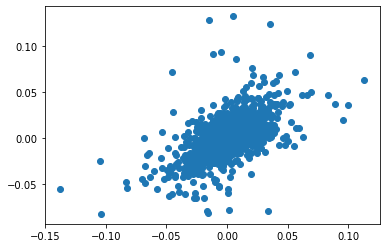

In [48]:
plt.scatter(aapl_diffs, amzn_diffs)
plt.show()

### The Two Betas 

covariance(x,y) / variance(y)  

In [49]:
# different more simple way of calculating covaraiance for a population (not a sample), or sufficiently large sample
def covariance(x,y):
    return (x*y).mean() - x.mean() * y.mean()

def beta(x,y):
    return covariance(x,y) / covariance(x,x)

In [50]:
beta1 = beta(aapl_diffs, amzn_diffs)
beta2 = beta(amzn_diffs, aapl_diffs)
# beta3 = beta(amzn_diffs, tsla_diffs)
# beta4 = beta(tsla_diffs, amzn_diffs)
print(beta1, beta2)
# print(beta3, beta4)

0.5778617742724593 0.545155911801736


If multiply them get the sqrt of the correlation coefficient  
If they are highly correlated beta(x,y) ~= 1/beta(y,x)

## Geometry of Beta (12)

Beta is gradient of the line of best fit for the graphs of the differentials plotted against each other  
- example of amzn and aapl scatter plots  

Find the beta using linear regression then  



In [51]:
def linear_regression(design_matrix, target_vector):
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

Want to take one of the series as the X and one as the Y  
The Y is fine but the X is the wrong type  
Need the X to be a 2d matrix but currently a 1d series  
Do that by this way:  

In [52]:
# 1 = 1 column
# -1 = how many rows, -1 means let computer figure out how many rows are needed
def convert_to_2d(original):
    X = original.to_numpy().reshape((-1,1))
    return X
    


In [53]:
beta_amzn_aapl = linear_regression(convert_to_2d(aapl_diffs), amzn_diffs)
beta_aapl_amzn = linear_regression(convert_to_2d(amzn_diffs), aapl_diffs)
print(beta_aapl_amzn, beta_amzn_aapl)

[0.54660352] [0.58020823]


## Shape of Matrices

Refere to 
[slides](https://learn.london.ac.uk/pluginfile.php/267138/mod_resource/content/5/Topic%209%20Lecture12%20%20geometry%20of%20beta.pdf)

Numbers slightly different frome before because they are **without bias**

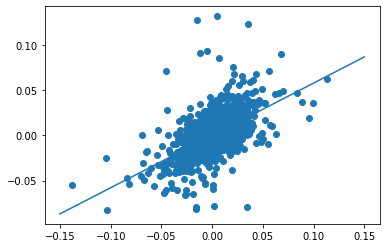

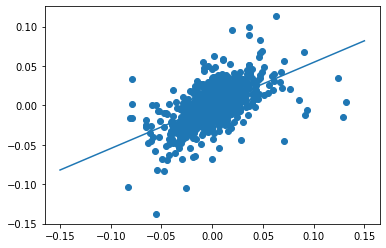

In [54]:
plt.scatter(aapl_diffs, amzn_diffs)
xs = np.linspace(-0.15,0.15)
plt.plot(xs, xs * beta_amzn_aapl)
plt.show()

plt.scatter(amzn_diffs, aapl_diffs)
xs = np.linspace(-0.15,0.15)
plt.plot(xs, xs * beta_aapl_amzn)
plt.show()

## Finishing Beta: Risk and Covariance
[Lecture](https://learn.london.ac.uk/mod/page/view.php?id=79343&forceview=1)  
Working with matrices

Standard deviation is a measure of risk

Need an equivalent of Standard deviation

Start with the variance (standard deviation = sqrt of variance)

### Covariance Matrix



In [55]:
def covariance_matrix(values):
    results = np.zeros((len(values), len(values)))
    for i in range(len(values)):
        for j in range(len(values)):
            results[i,j] = covariance(values[i], values[j])
    return results

covar = covariance_matrix([aapl_diffs, amzn_diffs, tsla_diffs])
covar

array([[0.00033458, 0.00019334, 0.00024695],
       [0.00019334, 0.00035466, 0.000233  ],
       [0.00024695, 0.000233  , 0.00119724]])

- each element is covariance between 2 series
- graph is symmetric
- diagonal elements are the variances

Need the equivalent of the square root - get standard deviation?

Given M, need L such that:  
    -  ```L transpose * L = M```  
This is the equivalent of the square root  
Called the **Cholesky** decomposition - exists for all covariance matrices

In [56]:
L = np.linalg.cholesky(covar)
L

array([[0.01829164, 0.        , 0.        ],
       [0.01057004, 0.01558625, 0.        ],
       [0.01350064, 0.0057932 , 0.03132747]])



### Trajectories
prediction = last value + expected change + random bit (L @ np.random.randn(3))  
random bit = standard deviation * random number (normal dist variance 1, mean 0) - 3 is how many numbers getting


```
for i in range(2000):
    last_values = trajectories[-1,:]
    prediction = last_values + expectations + L @ np.random.randn(3)
    print(prediction)
```

``` 
expectations = np.array([aapl_diffs.mean(), amzn_diffs.mean(), tsla_diffs.mean()])
```

New prediction technique: model the next difference as the mean of all the past differences

In [57]:
for i in range(2000):
    last_values = trajectories[-1,:]
    prediction = last_values + expectations + L @ np.random.randn(3)
    print(prediction)

NameError: name 'trajectories' is not defined

### Modelling Risk
- supose had an equal value of each of these shares
- can use covariance matrix to predict risk in 2 ways:  
1. take sum of all the variances/covariances and take square root of that
    - higher estimate of risk
2. take sum of just the varainces (trace takes sum of diagonal) and take square root of that
    - lower estimate of risk

In [58]:
import math 

# 1. take sum of all the variances/covariances and take square root of that
print("std of daily return", math.sqrt(covar.sum()))

# 2. take sum of just the varainces (trace takes sum of diagonal) and take square root of that
print("std of daily return assuming independant share prices", math.sqrt(covar.trace()))


std of daily return 0.0568599783770077
std of dail return assuming independant share prices 0.04343362485167571


Lower risk value if assume all things are independant of one another.  
When in actuality there's a chance that if something was to go wrong in one stock price  
It could actually be related to same thing in a different stock you hold  

So the shares are not independant thus a higher risk